<a href="https://colab.research.google.com/github/mosrihari/FoundationalStudy/blob/main/GPT_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [2]:
GPT2_CFG = {
    "vocab_size"    : 50257,
    "emb_dim"       : 768,
    "n_heads"       : 12,
    "n_transformers": 12,
    "dropout"       : 0.1,
    "context_len"   : 1024,
    "qkv_bias"      : False
}

# Transformer Layer components

Transformer layer consists of


*   Layer Normalization
*   Feedforward neural network with GELU
*   Skip Connection
*   Masked Multi head attention

So we will implement each layers as a separate class which forms transformers





## Layer Normalization

### Scratchpad

In [3]:
input_layer = torch.randn((5,6))
print(input_layer)

torch.mean(input_layer,dim=-1)

tensor([[-0.3139,  0.5022, -0.9369, -1.0712,  0.7988, -0.8452],
        [ 0.3615, -0.6079, -0.1801, -0.8035, -0.3541,  0.2374],
        [ 2.8382, -0.2211, -0.4065, -0.6688, -1.3068, -0.1472],
        [-0.7794, -0.1992,  0.8268, -0.8106,  0.1289,  0.7278],
        [-2.6241, -0.3855, -0.8128, -1.7868, -1.3858, -0.1908]])


tensor([-0.3111, -0.2244,  0.0146, -0.0176, -1.1976])

### Main class

In [4]:
class LayerNormalization(torch.nn.Module):

  def __init__(self, eps):
    super().__init__()

    self.eps = eps #to avoid divide by 0
    self.scale = torch.nn.Parameter(torch.ones(GPT2_CFG['emb_dim']))
    self.shift = torch.nn.Parameter(torch.zeros(GPT2_CFG['emb_dim']))

  def forward(self, x):
    # we take mean and variance from the output layer
    # The output layer will have embedding_dim as column matrix
    # Hence the mean and variance should be across columns
    mean = torch.mean(x, dim=-1, keepdim=True) #normalize across columns -1
    variance = torch.var(x, dim=-1, unbiased=True, keepdim=True) # unbiased True for bressels correction
    # keepdim is mandatory as it preserves the dimension. Else, the mean and variance will be flattened vectors
    x = (x - mean) / (torch.sqrt(variance) + self.eps) # normalize
    return self.scale * x + self.shift # trainable params included


In [5]:
#small testing
input_matrix = [[1,2,3,4,5],
                [3,4,5,21,32],
                [12,324,233,5456,32],
                [12,34,3,6,1],
                [78,43,23,12,65]]

#input_matrix 5 * 5
input_matrix = torch.tensor(input_matrix).float()
LM = LayerNormalization(eps = 1e-5)
LM.scale = torch.nn.Parameter(torch.ones((5,5)))
LM.shift = torch.nn.Parameter(torch.zeros((5,5)))
output_normalized = LM(input_matrix)

print(output_normalized, output_normalized.shape, torch.mean(output_normalized, dim=-1), torch.var(output_normalized, dim=-1))

tensor([[-1.2649, -0.6325,  0.0000,  0.6325,  1.2649],
        [-0.7727, -0.6954, -0.6181,  0.6181,  1.4681],
        [-0.5047, -0.3734, -0.4117,  1.7861, -0.4963],
        [ 0.0597,  1.7008, -0.6117, -0.3879, -0.7609],
        [ 1.2215, -0.0434, -0.7661, -1.1637,  0.7517]], grad_fn=<AddBackward0>) torch.Size([5, 5]) tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.1921e-08, -4.7684e-08],
       grad_fn=<MeanBackward1>) tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<VarBackward0>)


In [6]:
LM = LayerNormalization(eps = 1e-5)
input_x = torch.randn((GPT2_CFG['context_len'], GPT2_CFG['emb_dim']))
output_normalized = LM(input_x)
output_normalized.shape, torch.mean(output_normalized), torch.var(output_normalized)
# Mean 0 and Variance 1

(torch.Size([1024, 768]),
 tensor(3.8805e-10, grad_fn=<MeanBackward0>),
 tensor(0.9987, grad_fn=<VarBackward0>))

## Feedforward with GELU

### GELU



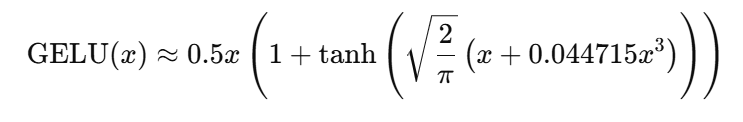

In [7]:
class GELU(torch.nn.Module):

  def __init__(self):
    super().__init__()

  def forward(self, x):
    # Inside GELU activation
    return 0.5 * x * (1 +
                      torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) *
                       (x + 0.044715 * torch.pow(x, 3))))

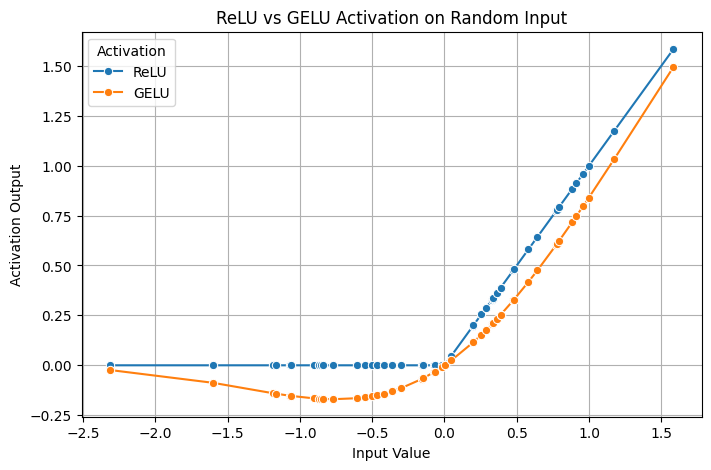

In [8]:
## We can do comparison between RELU and GELU as well
input_values = torch.randn(50)
relu_activation = torch.relu(input_values)
gelu = GELU()
gelu_activation = gelu(input_values)

df = pd.DataFrame({
    'Input': input_values.numpy(),
    'ReLU': relu_activation.numpy(),
    'GELU': gelu_activation.numpy()
})

df_melted = df.melt(id_vars='Input', var_name='Activation', value_name='Output')

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_melted, x='Input', y='Output', hue='Activation', marker='o')
plt.title('ReLU vs GELU Activation on Random Input')
plt.xlabel('Input Value')
plt.ylabel('Activation Output')
plt.grid(True)
plt.show()

### Feedforward network

In [9]:
class FeedforwardNetwork(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.layers = torch.nn.Sequential(
        torch.nn.Linear(GPT2_CFG['emb_dim'], GPT2_CFG['emb_dim']*4), #expansion
        GELU(), #activation defined by us
        torch.nn.Linear(GPT2_CFG['emb_dim'] * 4, GPT2_CFG['emb_dim']) #contraction
    )

  def forward(self, x):
    x = self.layers(x)
    return x

In [10]:
input_x = torch.randn((GPT2_CFG['emb_dim'], GPT2_CFG['emb_dim']))
FFN = FeedforwardNetwork()
final_output = FFN(input_x)

In [11]:
final_output.shape

torch.Size([768, 768])

In [12]:
for name, param in FFN.named_parameters():
    print(name, param.shape)

layers.0.weight torch.Size([3072, 768])
layers.0.bias torch.Size([3072])
layers.2.weight torch.Size([768, 3072])
layers.2.bias torch.Size([768])


## Shortcut Connection understanding

We are just going to check the Shortcut connection to understand how it works for multiple layers. This is not part of implementation class as it is passing previous input to further outputs only. Which we will do in main transformer class

In [13]:
class ShortCutConnection(torch.nn.Module):

  def __init__(self, shortcut=True):
    super().__init__()
    self.layers_list = torch.nn.ModuleList([
        torch.nn.Sequential(torch.nn.Linear(3,6), GELU()),
        torch.nn.Sequential(torch.nn.Linear(6,6), GELU()),
        torch.nn.Sequential(torch.nn.Linear(6,6), GELU()),
        torch.nn.Sequential(torch.nn.Linear(6,6), GELU()),
        torch.nn.Sequential(torch.nn.Linear(6,1))]
        )
    self.shortcut = shortcut

  def forward(self, x):
    for e, layers in enumerate(self.layers_list):
      layer_out = layers(x)

      if self.shortcut and layer_out.shape == x.shape:
          x = x + layer_out
      else:
          x = layer_out
    return x

In [14]:
x = torch.tensor([-1.,0.,1.])
scc = ShortCutConnection(shortcut=True)
no_scc = ShortCutConnection(shortcut = False)

In [15]:
## Test the shortcut connection
target = torch.tensor([-1.])
loss = torch.nn.MSELoss()

predicted_with_shortcut = scc(x)
predicted_wo_shortcut = no_scc(x)

loss_value_with_shortcut = loss(predicted_with_shortcut, target)
loss_value_wo_shortcut = loss(predicted_wo_shortcut, target)


loss_value_with_shortcut.backward()
loss_value_wo_shortcut.backward()

print("With shortcut connection - no vanishing gradient")
for e, param in scc.named_parameters():
  if('weight' in e):
    print(f"{param.grad.abs().mean().item()}")
print("\n")
print("Without shortcut connection -  vanishing gradient")
for e, param in no_scc.named_parameters():
  if('weight' in e):
    print(f"{param.grad.abs().mean().item()}")

With shortcut connection - no vanishing gradient
0.1466420739889145
0.06692642718553543
0.05276026949286461
0.050271518528461456
0.44439709186553955


Without shortcut connection -  vanishing gradient
0.003944466356188059
0.0030208516400307417
0.013405474834144115
0.026505611836910248
0.22657082974910736


## Masked Multi head attention

## Scratchpad

In [16]:
embeddings = torch.tensor([[0.43, 0.15, 0.89], #your
                            [0.55, 0.87, 0.66], #journey
                            [0.57, 0.85, 0.64], #starts
                            [0.22, 0.58, 0.33], #with
                            [0.77, 0.25, 0.10], #one
                            [0.05, 0.80, 0.55]]) #step
embedding_batch = torch.stack([embeddings, embeddings], dim = 0)

In [17]:
embedding_batch.shape

torch.Size([2, 6, 3])

In [18]:
w_q = torch.nn.Linear(3, 3 * 2) # dim_in, embedding_dim * n_head
w_k = torch.nn.Linear(3, 3 * 2)
w_v = torch.nn.Linear(3, 3 * 2)

q = w_q(embedding_batch)
k = w_k(embedding_batch)
v = w_v(embedding_batch)

q.shape, q

(torch.Size([2, 6, 6]),
 tensor([[[ 0.5069,  0.3514, -0.7723,  0.5724,  0.8592,  0.8210],
          [ 0.6969,  0.3030, -0.5614,  0.8339,  0.7274,  1.0082],
          [ 0.6716,  0.2919, -0.5656,  0.8094,  0.7262,  0.9952],
          [ 0.5551,  0.3122, -0.3511,  0.7140,  0.5949,  0.6629],
          [ 0.0929,  0.0870, -0.5545,  0.2515,  0.6437,  0.5460],
          [ 0.8141,  0.4200, -0.3247,  0.9639,  0.6166,  0.8170]],
 
         [[ 0.5069,  0.3514, -0.7723,  0.5724,  0.8592,  0.8210],
          [ 0.6969,  0.3030, -0.5614,  0.8339,  0.7274,  1.0082],
          [ 0.6716,  0.2919, -0.5656,  0.8094,  0.7262,  0.9952],
          [ 0.5551,  0.3122, -0.3511,  0.7140,  0.5949,  0.6629],
          [ 0.0929,  0.0870, -0.5545,  0.2515,  0.6437,  0.5460],
          [ 0.8141,  0.4200, -0.3247,  0.9639,  0.6166,  0.8170]]],
        grad_fn=<ViewBackward0>))

In [19]:
q = q.view(2, 6, 2, 3) # batch, context_length, head, dim
k = k.view(2, 6, 2, 3)
v = v.view(2, 6, 2, 3)

q # I have a first 2 rows is "your" value which has 2 heads , 3rd and 4th row is "journey" which has 2 heads

#qk(transpose)
# grouped by context length now . But change it to head group


tensor([[[[ 0.5069,  0.3514, -0.7723],
          [ 0.5724,  0.8592,  0.8210]],

         [[ 0.6969,  0.3030, -0.5614],
          [ 0.8339,  0.7274,  1.0082]],

         [[ 0.6716,  0.2919, -0.5656],
          [ 0.8094,  0.7262,  0.9952]],

         [[ 0.5551,  0.3122, -0.3511],
          [ 0.7140,  0.5949,  0.6629]],

         [[ 0.0929,  0.0870, -0.5545],
          [ 0.2515,  0.6437,  0.5460]],

         [[ 0.8141,  0.4200, -0.3247],
          [ 0.9639,  0.6166,  0.8170]]],


        [[[ 0.5069,  0.3514, -0.7723],
          [ 0.5724,  0.8592,  0.8210]],

         [[ 0.6969,  0.3030, -0.5614],
          [ 0.8339,  0.7274,  1.0082]],

         [[ 0.6716,  0.2919, -0.5656],
          [ 0.8094,  0.7262,  0.9952]],

         [[ 0.5551,  0.3122, -0.3511],
          [ 0.7140,  0.5949,  0.6629]],

         [[ 0.0929,  0.0870, -0.5545],
          [ 0.2515,  0.6437,  0.5460]],

         [[ 0.8141,  0.4200, -0.3247],
          [ 0.9639,  0.6166,  0.8170]]]], grad_fn=<ViewBackward0>)

In [20]:
q = q.transpose(2,1) # interchange context with head
# now it is first head, second head for the first batch then first head, second head for the second batch
k = k.transpose(2,1)
#2,2,6,3 matmul 2,2,6,3 and if you want qkT , transpose k with 2,3
print()
numerator = q @ k.transpose(2,3)
numerator


tensor([[[[ 1.0872,  1.0336,  1.0182,  0.9021,  0.6557,  1.0630],
          [ 1.2123,  1.1667,  1.1529,  0.9581,  0.7821,  1.1082],
          [ 1.1769,  1.1347,  1.1211,  0.9345,  0.7568,  1.0827],
          [ 0.9733,  0.9058,  0.8963,  0.7414,  0.6326,  0.8464],
          [ 0.3584,  0.3691,  0.3600,  0.3595,  0.1799,  0.4487],
          [ 1.3381,  1.2392,  1.2281,  0.9894,  0.8918,  1.1162]],

         [[ 0.1095,  0.4397,  0.4302,  0.2756,  0.1309,  0.3827],
          [ 0.3331,  0.6018,  0.5980,  0.4481,  0.4210,  0.4976],
          [ 0.3164,  0.5879,  0.5839,  0.4350,  0.4041,  0.4860],
          [ 0.3005,  0.4667,  0.4615,  0.3477,  0.2844,  0.4081],
          [-0.0429,  0.2349,  0.2267,  0.1156, -0.0176,  0.2056],
          [ 0.4678,  0.6134,  0.6099,  0.4837,  0.4606,  0.5287]]],


        [[[ 1.0872,  1.0336,  1.0182,  0.9021,  0.6557,  1.0630],
          [ 1.2123,  1.1667,  1.1529,  0.9581,  0.7821,  1.1082],
          [ 1.1769,  1.1347,  1.1211,  0.9345,  0.7568,  1.0827],
    

In [21]:
numerator.shape
# boolean mask with context length
boolean_mask_matrix = torch.triu(torch.ones(6,6).bool(),diagonal=1)
numerator.masked_fill_(boolean_mask_matrix, value=-np.inf)
numerator

tensor([[[[ 1.0872,    -inf,    -inf,    -inf,    -inf,    -inf],
          [ 1.2123,  1.1667,    -inf,    -inf,    -inf,    -inf],
          [ 1.1769,  1.1347,  1.1211,    -inf,    -inf,    -inf],
          [ 0.9733,  0.9058,  0.8963,  0.7414,    -inf,    -inf],
          [ 0.3584,  0.3691,  0.3600,  0.3595,  0.1799,    -inf],
          [ 1.3381,  1.2392,  1.2281,  0.9894,  0.8918,  1.1162]],

         [[ 0.1095,    -inf,    -inf,    -inf,    -inf,    -inf],
          [ 0.3331,  0.6018,    -inf,    -inf,    -inf,    -inf],
          [ 0.3164,  0.5879,  0.5839,    -inf,    -inf,    -inf],
          [ 0.3005,  0.4667,  0.4615,  0.3477,    -inf,    -inf],
          [-0.0429,  0.2349,  0.2267,  0.1156, -0.0176,    -inf],
          [ 0.4678,  0.6134,  0.6099,  0.4837,  0.4606,  0.5287]]],


        [[[ 1.0872,    -inf,    -inf,    -inf,    -inf,    -inf],
          [ 1.2123,  1.1667,    -inf,    -inf,    -inf,    -inf],
          [ 1.1769,  1.1347,  1.1211,    -inf,    -inf,    -inf],
    

In [22]:
v.shape[3]

3

In [23]:
# softmax on top
attention_score = numerator / np.sqrt(v.shape[3])
print(attention_score)
print("========")
attention_weight = torch.softmax(attention_score, dim=-1)
print(attention_weight)

tensor([[[[ 0.6277,    -inf,    -inf,    -inf,    -inf,    -inf],
          [ 0.6999,  0.6736,    -inf,    -inf,    -inf,    -inf],
          [ 0.6795,  0.6551,  0.6472,    -inf,    -inf,    -inf],
          [ 0.5619,  0.5230,  0.5175,  0.4280,    -inf,    -inf],
          [ 0.2069,  0.2131,  0.2079,  0.2075,  0.1038,    -inf],
          [ 0.7725,  0.7154,  0.7091,  0.5713,  0.5149,  0.6444]],

         [[ 0.0632,    -inf,    -inf,    -inf,    -inf,    -inf],
          [ 0.1923,  0.3474,    -inf,    -inf,    -inf,    -inf],
          [ 0.1827,  0.3394,  0.3371,    -inf,    -inf,    -inf],
          [ 0.1735,  0.2694,  0.2664,  0.2008,    -inf,    -inf],
          [-0.0248,  0.1356,  0.1309,  0.0667, -0.0101,    -inf],
          [ 0.2701,  0.3542,  0.3521,  0.2793,  0.2659,  0.3052]]],


        [[[ 0.6277,    -inf,    -inf,    -inf,    -inf,    -inf],
          [ 0.6999,  0.6736,    -inf,    -inf,    -inf,    -inf],
          [ 0.6795,  0.6551,  0.6472,    -inf,    -inf,    -inf],
    

In [24]:
attention_weight.shape, v.shape

(torch.Size([2, 2, 6, 6]), torch.Size([2, 6, 2, 3]))

In [25]:
v = v.transpose(2,1) # also group by head

In [26]:
v.shape

torch.Size([2, 2, 6, 3])

In [27]:
# context vector is this scale multiplied with v
context_vector = attention_weight @ v

In [28]:
context_vector

tensor([[[[-0.0557,  0.0224, -0.4019],
          [ 0.1043, -0.0406, -0.5828],
          [ 0.1552, -0.0661, -0.6462],
          [ 0.2144, -0.1089, -0.6164],
          [ 0.2030, -0.1718, -0.6395],
          [ 0.2453, -0.1553, -0.6111]],

         [[ 0.7016,  0.0792,  0.5009],
          [ 0.5794,  0.0652,  0.3878],
          [ 0.5443,  0.0592,  0.3543],
          [ 0.5016, -0.0058,  0.2708],
          [ 0.5022, -0.0402,  0.2517],
          [ 0.4756, -0.0566,  0.2141]]],


        [[[-0.0557,  0.0224, -0.4019],
          [ 0.1043, -0.0406, -0.5828],
          [ 0.1552, -0.0661, -0.6462],
          [ 0.2144, -0.1089, -0.6164],
          [ 0.2030, -0.1718, -0.6395],
          [ 0.2453, -0.1553, -0.6111]],

         [[ 0.7016,  0.0792,  0.5009],
          [ 0.5794,  0.0652,  0.3878],
          [ 0.5443,  0.0592,  0.3543],
          [ 0.5016, -0.0058,  0.2708],
          [ 0.5022, -0.0402,  0.2517],
          [ 0.4756, -0.0566,  0.2141]]]], grad_fn=<UnsafeViewBackward0>)

In [29]:
context_vector.shape  # batch, head, context_length, dim
# i wanted to have this shape batch, context_length, head, dim

context_vector = context_vector.transpose(2,1)
# then combine the first 2 values for each
context_vector

tensor([[[[-0.0557,  0.0224, -0.4019],
          [ 0.7016,  0.0792,  0.5009]],

         [[ 0.1043, -0.0406, -0.5828],
          [ 0.5794,  0.0652,  0.3878]],

         [[ 0.1552, -0.0661, -0.6462],
          [ 0.5443,  0.0592,  0.3543]],

         [[ 0.2144, -0.1089, -0.6164],
          [ 0.5016, -0.0058,  0.2708]],

         [[ 0.2030, -0.1718, -0.6395],
          [ 0.5022, -0.0402,  0.2517]],

         [[ 0.2453, -0.1553, -0.6111],
          [ 0.4756, -0.0566,  0.2141]]],


        [[[-0.0557,  0.0224, -0.4019],
          [ 0.7016,  0.0792,  0.5009]],

         [[ 0.1043, -0.0406, -0.5828],
          [ 0.5794,  0.0652,  0.3878]],

         [[ 0.1552, -0.0661, -0.6462],
          [ 0.5443,  0.0592,  0.3543]],

         [[ 0.2144, -0.1089, -0.6164],
          [ 0.5016, -0.0058,  0.2708]],

         [[ 0.2030, -0.1718, -0.6395],
          [ 0.5022, -0.0402,  0.2517]],

         [[ 0.2453, -0.1553, -0.6111],
          [ 0.4756, -0.0566,  0.2141]]]], grad_fn=<TransposeBackward0>)

In [30]:
context_vector.contiguous().view(2,6,6)

tensor([[[-0.0557,  0.0224, -0.4019,  0.7016,  0.0792,  0.5009],
         [ 0.1043, -0.0406, -0.5828,  0.5794,  0.0652,  0.3878],
         [ 0.1552, -0.0661, -0.6462,  0.5443,  0.0592,  0.3543],
         [ 0.2144, -0.1089, -0.6164,  0.5016, -0.0058,  0.2708],
         [ 0.2030, -0.1718, -0.6395,  0.5022, -0.0402,  0.2517],
         [ 0.2453, -0.1553, -0.6111,  0.4756, -0.0566,  0.2141]],

        [[-0.0557,  0.0224, -0.4019,  0.7016,  0.0792,  0.5009],
         [ 0.1043, -0.0406, -0.5828,  0.5794,  0.0652,  0.3878],
         [ 0.1552, -0.0661, -0.6462,  0.5443,  0.0592,  0.3543],
         [ 0.2144, -0.1089, -0.6164,  0.5016, -0.0058,  0.2708],
         [ 0.2030, -0.1718, -0.6395,  0.5022, -0.0402,  0.2517],
         [ 0.2453, -0.1553, -0.6111,  0.4756, -0.0566,  0.2141]]],
       grad_fn=<ViewBackward0>)

## Main class

In [31]:
class MaskedMultiheadAttention(torch.nn.Module):
  # deal with batches mainly.
  def __init__(self):
    super().__init__()
    #input dimension will be batch, context_length * emb_dimension

    self.w_q = torch.nn.Linear(GPT2_CFG['emb_dim'], GPT2_CFG['emb_dim'])
    self.w_k = torch.nn.Linear(GPT2_CFG['emb_dim'], GPT2_CFG['emb_dim'])
    self.w_v = torch.nn.Linear(GPT2_CFG['emb_dim'], GPT2_CFG['emb_dim'])
    self.n_heads = GPT2_CFG['n_heads']
    self.dim_per_head = GPT2_CFG['emb_dim'] // self.n_heads
    self.emb_dim = GPT2_CFG['emb_dim']
    self.context_length = GPT2_CFG['context_len']

  def forward(self, x):
    batch, token_length, emb_dim = x.shape
    torch.Size([2, 6, 768])

    q = self.w_q(x)  # 6 * (768)
    k = self.w_k(x)  # 6 * (768)
    v = self.w_v(x)  # 6 * (768)

    # reshape the q,k,v matrices
    q = q.view(batch, token_length, self.n_heads, self.dim_per_head)
    k = k.view(batch, token_length, self.n_heads, self.dim_per_head)
    v = v.view(batch, token_length, self.n_heads, self.dim_per_head)
    # Attention score calculation
    # interchange context with head
    q = q.transpose(2,1)
    k = k.transpose(2,1)
    # now it is first head, second head for the first batch then first head, second head for the second batch
    #batch,head,context_length,dim_per_head matmul batch,head,context_length,dim_per_head and if you want qkT , transpose k with 2,3
    attention_score_inter = q @ k.transpose(2,3) # batch, head,context, dim_per_head
    boolean_mask_matrix = torch.triu(
        torch.ones(self.context_length,self.context_length).bool(),
        diagonal=1)[:token_length, :token_length]
    attention_score_inter.masked_fill_(boolean_mask_matrix, value=-np.inf)

    attention_score = attention_score_inter / np.sqrt(self.emb_dim)
    attention_weight = torch.softmax(attention_score, dim=-1)

    v = v.transpose(2,1) # also group by head
    # context vector is this scale multiplied with v
    context_vector = attention_weight @ v
    # now change it to head, context_length, dim again (see scratch pad)
    context_vector = context_vector.transpose(2,1)
    # then combine the first 2 values for each
    context_vector = context_vector.contiguous().view(batch, token_length, self.emb_dim)
    # contiguous to have everything in one memory
    return context_vector

In [32]:
torch.triu(
        torch.ones(1024,1024).bool(),
        diagonal=1)[:6,:6]

tensor([[False,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True],
        [False, False, False, False,  True,  True],
        [False, False, False, False, False,  True],
        [False, False, False, False, False, False]])

In [33]:
#testing
embeddings = torch.randn((1024, 768)) #context, emb
embedding_batch = torch.stack([embeddings, embeddings], dim = 0)
embedding_batch.shape

torch.Size([2, 1024, 768])

In [34]:
mma = MaskedMultiheadAttention()

In [35]:
context_test = mma(embedding_batch)

In [36]:
context_test.shape

torch.Size([2, 1024, 768])

# Transformer block

In [37]:
class TransformerBlock(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_norm = LayerNormalization(1e-5)
    self.masked_multihead = MaskedMultiheadAttention()
    self.dropout = torch.nn.Dropout(GPT2_CFG['dropout'])
    self.ffn_with_GELU = FeedforwardNetwork()

  def forward(self, x):
    # implementation of transformer with shortcut connection
    first_shortcut_addition = x
    x = self.layer_norm(x)
    x = self.masked_multihead(x)
    x = self.dropout(x)
    x = x + first_shortcut_addition

    second_shortcut_addition = x
    x = self.layer_norm(x)
    x = self.ffn_with_GELU(x)
    x = self.dropout(x)
    x = x + second_shortcut_addition

    return x


In [38]:
#testing
embeddings = torch.randn((1024, 768)) #context, emb
embedding_batch = torch.stack([embeddings, embeddings], dim = 0)
embedding_batch.shape

torch.Size([2, 1024, 768])

In [39]:
trf = TransformerBlock()

In [40]:
trf_output = trf(embedding_batch)

In [41]:
trf_output.shape

torch.Size([2, 1024, 768])

In [42]:
trans = torch.nn.Sequential(
    *[TransformerBlock() for _ in range(GPT2_CFG['n_transformers'])]
)

trf_output = trans(embedding_batch)

In [43]:
trf_output.shape

torch.Size([2, 1024, 768])

# GPT2 implementation

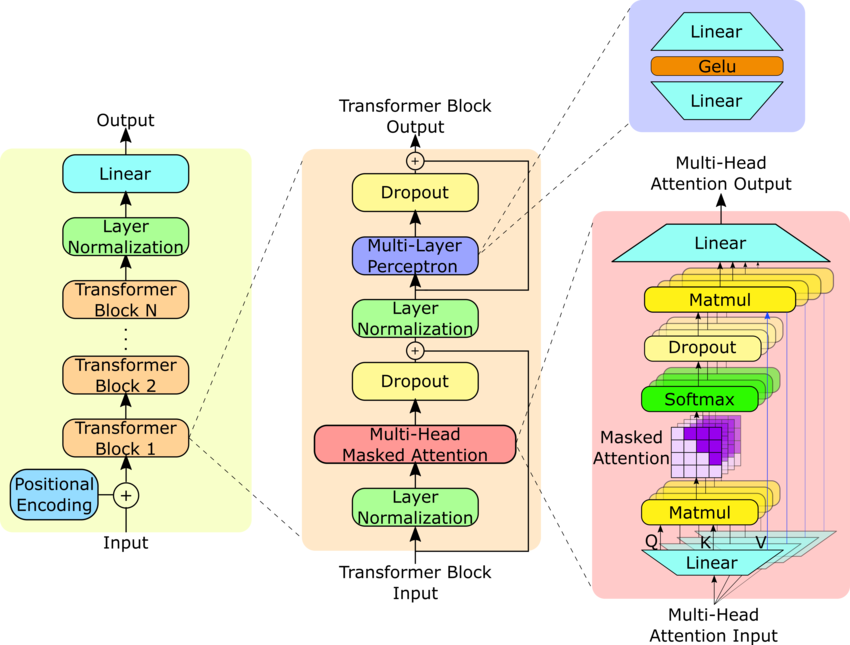

## Scratchpad

In [44]:
import tiktoken

In [45]:
tokenizer = tiktoken.get_encoding("gpt2")
text = "Hello, how are you?"
tokens = tokenizer.encode(text)

In [46]:
tokenizer.max_token_value

50256

In [47]:
tokens

[15496, 11, 703, 389, 345, 30]

In [48]:
tokenizer.decode(tokens)

'Hello, how are you?'

In [49]:
tokens

[15496, 11, 703, 389, 345, 30]

In [50]:
emb = torch.nn.Embedding(GPT2_CFG['vocab_size'], GPT2_CFG['emb_dim'])

In [51]:
GPT2_CFG['vocab_size']

50257

In [52]:
vocab = torch.arange(0, GPT2_CFG['vocab_size'])
x = emb(vocab)

In [53]:
x[tokens].shape

torch.Size([6, 768])

## Main class

In [54]:
class GPT2_small(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.embedding_layer = torch.nn.Embedding(GPT2_CFG['vocab_size'], GPT2_CFG['emb_dim'])
    self.positional_emb = torch.nn.Embedding(GPT2_CFG['context_len'], GPT2_CFG['emb_dim'])
    # 12 layers of transformers block
    self.trf = torch.nn.Sequential(
        *[TransformerBlock() for _ in range(GPT2_CFG['n_transformers'])]
    )
    self.norm_layer = LayerNormalization(1e-5)
    self.out_layer = torch.nn.Linear(GPT2_CFG['emb_dim'], GPT2_CFG['vocab_size'], bias=False)

  def forward(self, x):

    batch, seq_length = x.shape
    emb = self.embedding_layer(x)
    pos_embeds = self.positional_emb(torch.arange(seq_length, device=x.device))
    x = emb + pos_embeds
    x = self.trf(x)
    # output layer
    x = self.norm_layer(x)
    x = self.out_layer(x)
    return x

In [55]:
tokenizer = tiktoken.get_encoding("gpt2")
text = "Hello, how are you?"
text2 = "Hello, Hi I am your"
tokens = tokenizer.encode(text)
tokens2 = tokenizer.encode(text2)

In [56]:
tokens_batch = torch.stack((torch.tensor(tokens), torch.tensor(tokens2)), dim=0)

In [57]:
gpt2_model = GPT2_small()
output = gpt2_model(tokens_batch)
# need to look at batches

# Generating the next token

## Scratchpad

In [60]:
gpt2_model.eval()
for _ in range(4):

    token_batch_compressed = tokens_batch[:,-GPT2_CFG['context_len']:] # if more than context length, compress else its okay

    with torch.no_grad():
      output_logits = gpt2_model(token_batch_compressed)

    # consider only the last value to predict next work
    output_logits = output_logits[:,-1,:]
    output_logits = torch.softmax(output_logits, dim = -1)
    output_argindex = torch.argmax(output_logits, dim = -1, keepdim=True)

    tokens_batch = torch.cat((tokens_batch, output_argindex), dim=-1)

In [61]:
tokens_batch

tensor([[15496,    11,   703,   389,   345,    30, 11597, 34144, 22581,  9539],
        [15496,    11, 15902,   314,   716,   534, 45094, 31214, 19202, 49517]])

In [62]:
tokens_batch

tensor([[15496,    11,   703,   389,   345,    30, 11597, 34144, 22581,  9539],
        [15496,    11, 15902,   314,   716,   534, 45094, 31214, 19202, 49517]])

In [63]:
argindex = torch.argmax(tokens_batch, dim=-1, keepdim=True)
argindex

tensor([[7],
        [9]])

In [64]:
torch.cat((tokens_batch, argindex), dim=-1)

tensor([[15496,    11,   703,   389,   345,    30, 11597, 34144, 22581,  9539,
             7],
        [15496,    11, 15902,   314,   716,   534, 45094, 31214, 19202, 49517,
             9]])

In [65]:
tokens_batch[:, argindex]

tensor([[[34144],
         [ 9539]],

        [[31214],
         [49517]]])

## Main function

In [66]:
def generate_next_token(gpt2_model, token_batch, num_tokens_required):

  for _ in range(num_tokens_required):

    token_batch_compressed = token_batch[:,-GPT2_CFG['context_len']:] # if more than context length, compress else its okay

    with torch.no_grad():
      output_logits = gpt2_model(token_batch_compressed)

    # consider only the last value to predict next word
    output_logits = output_logits[:,-1,:]
    output_logits = torch.softmax(output_logits, dim = -1)
    output_argindex = torch.argmax(output_logits, dim = -1, keepdim=True)

    token_batch = torch.cat((token_batch, output_argindex), dim=-1)
  return token_batch

In [67]:
gpt2_model.eval()
token_batch_generated = generate_next_token(gpt2_model, tokens_batch, 5)

In [68]:
token_batch_generated.shape

torch.Size([2, 15])

In [69]:
decoded_texts = [tokenizer.decode(row.tolist()) for row in token_batch_generated]
decoded_texts

['Hello, how are you? Thingsactus brace stages preferred ventured Falling inner Falling',
 'Hello, Hi I am youraban MTVilogy712 dietsash Inside becomes blaming']

# Loss function - Cross entropy and Perplexity Error

Cross entropy loss is calculated by


*   Finding the true index from the logits generated by the model
*   Taking the Log of each logits and then find the mean of it.
*   Finally taking the negative value so that we can minimize the loss function

Now we are going to use real dataset and then use that in the model. Finally calculate the losses



In [58]:
from torch.utils.data import Subset

In [59]:
with open("verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [60]:
# for easing the training process, let us consider the context length to be 256 instead of 1024
GPT2_CFG = {
    "vocab_size"    : 50257,
    "emb_dim"       : 768,
    "n_heads"       : 12,
    "n_transformers": 12,
    "dropout"       : 0.1,
    "context_len"   : 256, # changed here
    "qkv_bias"      : False
}

In [61]:
class TextData(Dataset):

  def __init__(self, text_data):

    self.token_ids = tokenizer.encode(text_data,allowed_special={'<|endoftext|>'})
    self.max_length = len(self.token_ids)
    self.input_ids = []
    self.target_ids = []
    for i in range(0, self.max_length - GPT2_CFG['context_len'], GPT2_CFG['context_len']):
      input_ids = self.token_ids[i:i+GPT2_CFG['context_len']]
      target_ids = self.token_ids[i+1:i+1+GPT2_CFG['context_len']]
      self.input_ids.append(input_ids)
      self.target_ids.append(target_ids)
    self.input_ids = torch.tensor(self.input_ids)
    self.target_ids = torch.tensor(self.target_ids)

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.target_ids[idx]

In [62]:
data = TextData(raw_text)

In [63]:
#90% training and 10% validation
train_end_idx = int(len(data) * 0.9)

In [64]:
len(data)

20

In [65]:
train_indices = list(range(train_end_idx))
valid_indices = list(range(train_end_idx, len(data)))

train_data = Subset(data, train_indices)
valid_data = Subset(data, valid_indices)

In [66]:
len(train_data)

18

In [67]:
train_dataloader = DataLoader(
        train_data,
        batch_size=2,
        shuffle=True,
        drop_last=True,
        num_workers=0
    )

valid_dataloader = DataLoader(
        valid_data,
        batch_size=2,
        shuffle=True,
        drop_last=True,
        num_workers=0
    )

In [68]:
len(train_dataloader)

9

In [69]:
data_iter = iter(train_dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  284,  1234,  8737,   656, 19133,   553,   373,   530,   286,   262,
          7877,    72,  3150,   339,  8104,   866,  1973,   262, 37918,   411,
           290,  8465,   286,   281, 33954,   271,  3973,  9899, 14678, 40556,
            12, 11487,    11,   618,    11,   319,   257,  1568,  1110,    11,
           314,   550,   757,  1057,   625,   422, 22489, 40089,    26,   290,
          9074,    13,   402,   271, 10899,    11,   307,  3723,   319,   683,
            11,  2087,   329,   616, 35957,    25,   366, 14295,   318,   523,
         34813,   306,  8564,   284,   790,  1296,   286,  8737,   526,   198,
           198, 43920,  3619,     0,   632,   550,  1464,   587,   465, 10030,
           284,   423,  1466,   910,   884,  1243,   286,   683,    25,   262,
          1109,   815,   307,   900,   866,   287,  1070,   268,  2288,    13,
          1867,  7425,   502,   783,   373,   326,    11,   329,   262,   717,
           640,    11,   339,   581,  4714,   262, 

In [70]:
for batch in train_dataloader:
    input_ids, target_ids = batch
    with torch.no_grad():
        output_logits = gpt2_model(input_ids)
    break

In [71]:
output_logits[0].shape

torch.Size([256, 50257])

In [72]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    for i, (input_batch, target_batch) in enumerate(train_dataloader):
        loss = calc_loss_batch(input_batch, target_batch, gpt2_model, device)
        total_loss += loss.item()
    return total_loss / num_batches

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_dataloader, gpt2_model, device, 2)

# Training loop

## Naive predictions of largest prob value

In [74]:
from torch.optim import AdamW
from tqdm import tqdm

In [75]:
tokenizer = tiktoken.get_encoding("gpt2")

text = "Every effort moves you "
tokens = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
tokens_batch = torch.tensor(tokens).view(-1, len(tokens))

In [76]:
tokens_batch.shape

torch.Size([1, 5])

In [89]:
EPOCHS = 10


num_tokens_required = 10
gpt2_model = GPT2_small()
optimizer = AdamW(gpt2_model.parameters(), lr=5e-4) # learning rate used in gpt2 small

for e in tqdm(range(EPOCHS)):

  gpt2_model.train()
  total_loss = 0.
  for i, (input_batch, target_batch) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    optimizer.zero_grad()
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = gpt2_model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(f"Training Loss after Epoch {e}==> {total_loss}")
  print("Testing for sample sentences \n")
  token_batch_generated = generate_next_token(gpt2_model, tokens_batch, num_tokens_required)
  decoded_texts = [tokenizer.decode(row.tolist()) for row in token_batch_generated]
  print(f"Decoded Text after epoch {e} ==> {decoded_texts}")
  if(e % 2 == 0):
    gpt2_model.eval()
    with torch.no_grad():
      for i, (input_batch, target_batch) in enumerate(valid_dataloader):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        valid_logits = gpt2_model(input_batch)
        valid_loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        print(f"Validation Loss after Epoch {e}==> {valid_loss}")

KeyboardInterrupt: 

In [ ]:
# Even though we have generated texts, the training loss keeps reducing but the validation loss remains stagnant
# classic case of overfitting
# To avoid this we use Temperature and top-k sampling

## Avoiding overfitting issue

### Temperature

We divide the output by temperature which changes the distribution
Then we choose multinomial sampling to choose probabilistic words from the new distribution

For example:
if the temperature scaling and softmax are performed, we get the prob for each word

[0.2, 0.33, 0.4, 0.01, ...]

This list will be passed for multinomial sampling and 40% chance the index 2 will be selected from this sample

In [77]:
import seaborn as sns

In [78]:
def generate_next_token_with_temp(gpt2_model, token_batch, num_tokens_required, temperature):

  for _ in range(num_tokens_required):

    token_batch_compressed = token_batch[:,-GPT2_CFG['context_len']:] # if more than context length, compress else its okay

    with torch.no_grad():
      output_logits = gpt2_model(token_batch_compressed)

    # consider only the last value to predict next word
    output_logits = output_logits[:,-1,:]
    output_logits = output_logits / temperature
    output_logits = torch.softmax(output_logits, dim = -1)
    output_temp = torch.multinomial(torch.softmax(output_logits, dim=-1), num_samples=1)

    token_batch = torch.cat((token_batch, output_temp), dim=-1)
  return token_batch

In [ ]:
EPOCHS = 7


num_tokens_required = 25
gpt2_model = GPT2_small()
optimizer = AdamW(gpt2_model.parameters(), lr=5e-4) # learning rate used in gpt2 small

for e in tqdm(range(EPOCHS)):

  gpt2_model.train()
  total_loss = 0.
  for i, (input_batch, target_batch) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    optimizer.zero_grad()
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = gpt2_model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(f"Training Loss after Epoch {e}==> {total_loss}")
  print("Testing for sample sentences \n")
  token_batch_generated = generate_next_token_with_temp(gpt2_model, tokens_batch, num_tokens_required, 1.5)
  decoded_texts = [tokenizer.decode(row.tolist()) for row in token_batch_generated]
  print(f"Decoded Text after epoch {e} ==> {decoded_texts}")
  if(e % 2 == 0):
    gpt2_model.eval()
    with torch.no_grad():
      for i, (input_batch, target_batch) in enumerate(valid_dataloader):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        valid_logits = gpt2_model(input_batch)
        valid_loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        print(f"Validation Loss after Epoch {e}==> {valid_loss}")

## Top k sampling

### Scratchpad

In [92]:
output_logits = gpt2_model(tokens_batch)

# consider only the last value to predict next word
output_logits = output_logits[:,-1,:]

In [93]:
output_logits

tensor([[ 0.0571,  0.7369,  0.6110,  ...,  0.9653,  0.6137, -0.3960]],
       grad_fn=<SliceBackward0>)

In [96]:
output_logits.topk(3)

torch.return_types.topk(
values=tensor([[2.2733, 2.2465, 2.1289]], grad_fn=<TopkBackward0>),
indices=tensor([[28098, 14713, 17451]]))

In [ ]:
output_logits.shape

In [106]:
out = torch.tensor([[8,2,3,4,5,6,0,0.5]])
topk = out.topk(3)

In [101]:
topk.values[0]

tensor([8., 6., 5.])

In [102]:
arg_lessk = torch.where(out[0] < topk.values[0][-1])

In [103]:
arg_lessk

(tensor([1, 2, 3, 6, 7]),)

In [104]:
out[0][arg_lessk] = -torch.inf

In [105]:
out

tensor([[8., -inf, -inf, -inf, 5., 6., -inf, -inf]])

### Main

In [79]:
def generate_next_token_with_temp_topk(gpt2_model, token_batch, num_tokens_required, temperature, top_k):

  for _ in range(num_tokens_required):

    token_batch_compressed = token_batch[:,-GPT2_CFG['context_len']:] # if more than context length, compress else its okay

    with torch.no_grad():
      output_logits = gpt2_model(token_batch_compressed)

    # consider only the last value to predict next word
    output_logits = output_logits[:,-1,:]

    # top k sampling
    topk = output_logits.topk(top_k)
    print(f"Top k values --> {topk}\n")
    last_max = topk.values[0][-1]
    print(f"Last max value --> {last_max}\n") # taking the last max value in top k
    arg_lessk = torch.where(output_logits[0] < last_max)
    output_logits[0][arg_lessk] = -torch.inf

    output_logits = output_logits / temperature
    output_logits = torch.softmax(output_logits, dim = -1)
    output_temp = torch.multinomial(torch.softmax(output_logits, dim=-1), num_samples=1)

    token_batch = torch.cat((token_batch, output_temp), dim=-1)
  return token_batch

In [81]:
#from bitsandbytes.optim import AdamW
gpt2_model = GPT2_small()
optimizer = AdamW(gpt2_model.parameters(), lr=5e-4) # learning rate used in gpt2 small

In [82]:
EPOCHS = 7


num_tokens_required = 25

for e in tqdm(range(EPOCHS)):

  gpt2_model.train()
  total_loss = 0.
  for i, (input_batch, target_batch) in tqdm(enumerate(train_dataloader),
                                             total=len(train_dataloader)):
    optimizer.zero_grad()
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = gpt2_model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(f"Training Loss after Epoch {e}==> {total_loss}")
  print("Testing for sample sentences \n")
  token_batch_generated = generate_next_token_with_temp_topk(gpt2_model,
                                                             tokens_batch,
                                                             num_tokens_required,
                                                             1.5,
                                                             3)
  decoded_texts = [tokenizer.decode(row.tolist()) for row in token_batch_generated]
  print(f"Decoded Text after epoch {e} ==> {decoded_texts}")
  if(e % 2 == 0):
    gpt2_model.eval()
    with torch.no_grad():
      for i, (input_batch, target_batch) in enumerate(valid_dataloader):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        valid_logits = gpt2_model(input_batch)
        valid_loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1),
                                                       target_batch.flatten())
        print(f"Validation Loss after Epoch {e}==> {valid_loss}")

100%|██████████| 9/9 [01:20<00:00,  8.93s/it]


Training Loss after Epoch 0==> 80.9632477760315
Testing for sample sentences 

Top k values --> torch.return_types.topk(
values=tensor([[6.7524, 6.1406, 6.1171]]),
indices=tensor([[ 11,  13, 262]]))

Last max value --> 6.1171088218688965

Top k values --> torch.return_types.topk(
values=tensor([[6.7050, 6.1937, 6.1665]]),
indices=tensor([[ 11, 262,  13]]))

Last max value --> 6.166528224945068

Top k values --> torch.return_types.topk(
values=tensor([[6.8672, 6.2853, 6.1440]]),
indices=tensor([[ 11,  13, 262]]))

Last max value --> 6.144034385681152

Top k values --> torch.return_types.topk(
values=tensor([[6.4677, 6.3198, 6.1561]]),
indices=tensor([[ 11,  13, 262]]))

Last max value --> 6.156132698059082

Top k values --> torch.return_types.topk(
values=tensor([[6.6587, 6.3335, 6.2344]]),
indices=tensor([[ 11,  13, 262]]))

Last max value --> 6.234399318695068

Top k values --> torch.return_types.topk(
values=tensor([[6.6898, 6.2881, 6.0233]]),
indices=tensor([[ 11,  13, 262]]))

Last

 14%|█▍        | 1/7 [01:27<08:42, 87.00s/it]

Validation Loss after Epoch 0==> 7.557392120361328



100%|██████████| 9/9 [01:15<00:00,  8.43s/it]


Training Loss after Epoch 1==> 57.855278968811035
Testing for sample sentences 

Top k values --> torch.return_types.topk(
values=tensor([[6.5650, 6.0451, 5.9546]]),
indices=tensor([[ 11,  13, 262]]))

Last max value --> 5.954579830169678

Top k values --> torch.return_types.topk(
values=tensor([[6.5877, 5.9688, 5.9589]]),
indices=tensor([[ 11,  13, 262]]))

Last max value --> 5.958922386169434

Top k values --> torch.return_types.topk(
values=tensor([[6.7564, 6.1783, 5.8681]]),
indices=tensor([[ 11,  13, 262]]))

Last max value --> 5.86806058883667

Top k values --> torch.return_types.topk(
values=tensor([[6.5920, 6.0381, 6.0177]]),
indices=tensor([[ 11, 262,  13]]))

Last max value --> 6.017655372619629

Top k values --> torch.return_types.topk(
values=tensor([[6.6981, 6.1907, 5.9496]]),
indices=tensor([[ 11,  13, 262]]))

Last max value --> 5.949570655822754

Top k values --> torch.return_types.topk(
values=tensor([[6.6762, 6.1409, 5.9004]]),
indices=tensor([[ 11,  13, 262]]))

Last

 29%|██▊       | 2/7 [02:46<06:53, 82.61s/it]

Top k values --> torch.return_types.topk(
values=tensor([[6.5197, 6.0406, 5.9390]]),
indices=tensor([[ 11,  13, 262]]))

Last max value --> 5.9389848709106445

Decoded Text after epoch 1 ==> ['Every effort moves you  defund hep Media Was KittyJane Phelps descendant http grievances rename � shards Tup tightening aboriginalJet DV contradiction cart Presbyter Na Gospel Information NC']



100%|██████████| 9/9 [01:16<00:00,  8.46s/it]


Training Loss after Epoch 2==> 52.546528816223145
Testing for sample sentences 

Top k values --> torch.return_types.topk(
values=tensor([[6.0264, 5.8933, 5.7464]]),
indices=tensor([[ 11, 284, 438]]))

Last max value --> 5.746376991271973

Top k values --> torch.return_types.topk(
values=tensor([[6.1524, 5.9081, 5.8826]]),
indices=tensor([[ 11, 262, 284]]))

Last max value --> 5.8826398849487305

Top k values --> torch.return_types.topk(
values=tensor([[6.7761, 6.3545, 6.1646]]),
indices=tensor([[ 11,  13, 262]]))

Last max value --> 6.164625644683838

Top k values --> torch.return_types.topk(
values=tensor([[6.3418, 6.1604, 6.0353]]),
indices=tensor([[262,  11, 438]]))

Last max value --> 6.035340785980225

Top k values --> torch.return_types.topk(
values=tensor([[6.5596, 6.1681, 6.1104]]),
indices=tensor([[262,  11,  13]]))

Last max value --> 6.110429286956787

Top k values --> torch.return_types.topk(
values=tensor([[6.7630, 6.1260, 6.0928]]),
indices=tensor([[ 11, 284,  13]]))

La

 43%|████▎     | 3/7 [04:08<05:30, 82.52s/it]

Validation Loss after Epoch 2==> 6.942900657653809



100%|██████████| 9/9 [01:15<00:00,  8.43s/it]


Training Loss after Epoch 3==> 49.14924955368042
Testing for sample sentences 

Top k values --> torch.return_types.topk(
values=tensor([[5.2906, 4.2153, 4.2054]]),
indices=tensor([[  1, 764,  40]]))

Last max value --> 4.2053937911987305

Top k values --> torch.return_types.topk(
values=tensor([[5.3977, 4.2515, 4.1941]]),
indices=tensor([[   1, 1544,  198]]))

Last max value --> 4.1941375732421875

Top k values --> torch.return_types.topk(
values=tensor([[5.1505, 3.7669, 3.7443]]),
indices=tensor([[ 11, 284, 286]]))

Last max value --> 3.7442805767059326

Top k values --> torch.return_types.topk(
values=tensor([[4.6953, 4.0981, 3.7092]]),
indices=tensor([[257, 683,  12]]))

Last max value --> 3.7091786861419678

Top k values --> torch.return_types.topk(
values=tensor([[4.5766, 3.5483, 3.3989]]),
indices=tensor([[257, 683, 284]]))

Last max value --> 3.39892840385437

Top k values --> torch.return_types.topk(
values=tensor([[5.6917, 3.6184, 3.5082]]),
indices=tensor([[11, 12,  1]]))

L

 57%|█████▋    | 4/7 [05:28<04:04, 81.44s/it]

Top k values --> torch.return_types.topk(
values=tensor([[6.1705, 4.8126, 4.2688]]),
indices=tensor([[   1,   40, 1544]]))

Last max value --> 4.268754959106445

Decoded Text after epoch 3 ==> ['Every effort moves you  Well nonsensical=[Success gently unlucky mainlineな displays scarf Democrats GastDie cram strategically join CEwaAllenSetupipientbenef Hockey masculinity Sue']



100%|██████████| 9/9 [01:16<00:00,  8.46s/it]


Training Loss after Epoch 4==> 45.92211389541626
Testing for sample sentences 

Top k values --> torch.return_types.topk(
values=tensor([[4.9767, 4.9739, 4.8240]]),
indices=tensor([[ 11, 286, 284]]))

Last max value --> 4.823954105377197

Top k values --> torch.return_types.topk(
values=tensor([[5.3116, 4.6793, 4.4620]]),
indices=tensor([[ 11, 284, 257]]))

Last max value --> 4.4620161056518555

Top k values --> torch.return_types.topk(
values=tensor([[6.1259, 6.0516, 5.0487]]),
indices=tensor([[ 11, 286, 257]]))

Last max value --> 5.0487260818481445

Top k values --> torch.return_types.topk(
values=tensor([[5.6233, 5.5953, 4.9490]]),
indices=tensor([[286, 257, 326]]))

Last max value --> 4.9489898681640625

Top k values --> torch.return_types.topk(
values=tensor([[5.1938, 5.1468, 4.9200]]),
indices=tensor([[257, 286,  11]]))

Last max value --> 4.919962406158447

Top k values --> torch.return_types.topk(
values=tensor([[6.6872, 5.5503, 5.1154]]),
indices=tensor([[ 11, 286, 326]]))

L

 71%|███████▏  | 5/7 [06:50<02:43, 81.65s/it]

Validation Loss after Epoch 4==> 7.346735000610352



100%|██████████| 9/9 [01:15<00:00,  8.43s/it]


Training Loss after Epoch 5==> 38.53252601623535
Testing for sample sentences 

Top k values --> torch.return_types.topk(
values=tensor([[5.4257, 4.7266, 4.5411]]),
indices=tensor([[284,  11, 832]]))

Last max value --> 4.541121482849121

Top k values --> torch.return_types.topk(
values=tensor([[5.3240, 4.6276, 4.1527]]),
indices=tensor([[284, 670, 465]]))

Last max value --> 4.152697563171387

Top k values --> torch.return_types.topk(
values=tensor([[6.1497, 5.5866, 5.0261]]),
indices=tensor([[284,  11, 257]]))

Last max value --> 5.026145935058594

Top k values --> torch.return_types.topk(
values=tensor([[6.1381, 6.0557, 5.5683]]),
indices=tensor([[326, 284, 257]]))

Last max value --> 5.568344593048096

Top k values --> torch.return_types.topk(
values=tensor([[5.9346, 5.1602, 4.5743]]),
indices=tensor([[ 326,  257, 9074]]))

Last max value --> 4.57428503036499

Top k values --> torch.return_types.topk(
values=tensor([[7.4161, 6.6184, 5.0839]]),
indices=tensor([[ 11, 284, 287]]))

La

 86%|████████▌ | 6/7 [08:10<01:21, 81.13s/it]

Top k values --> torch.return_types.topk(
values=tensor([[5.7726, 5.3733, 4.7889]]),
indices=tensor([[286, 284, 257]]))

Last max value --> 4.788885593414307

Decoded Text after epoch 5 ==> ['Every effort moves you  233 professor surpr widening convoy integers Calvin Russ Ni Shared justifiedaepernickjpg Kang Kare Milwaukee Legion bindlooking tele Shelter obstacles futile multiply believe']



100%|██████████| 9/9 [01:16<00:00,  8.50s/it]


Training Loss after Epoch 6==> 30.25392985343933
Testing for sample sentences 

Top k values --> torch.return_types.topk(
values=tensor([[5.7799, 5.0690, 4.9427]]),
indices=tensor([[314,  11, 284]]))

Last max value --> 4.942676544189453

Top k values --> torch.return_types.topk(
values=tensor([[6.4152, 5.8254, 5.6418]]),
indices=tensor([[373, 198, 470]]))

Last max value --> 5.6417694091796875

Top k values --> torch.return_types.topk(
values=tensor([[5.8227, 5.5879, 5.3694]]),
indices=tensor([[ 13, 284,  11]]))

Last max value --> 5.369417190551758

Top k values --> torch.return_types.topk(
values=tensor([[8.5061, 6.5659, 6.4619]]),
indices=tensor([[257, 465, 683]]))

Last max value --> 6.461885452270508

Top k values --> torch.return_types.topk(
values=tensor([[6.5149, 5.3262, 5.2930]]),
indices=tensor([[ 616,  314, 9074]]))

Last max value --> 5.293006420135498

Top k values --> torch.return_types.topk(
values=tensor([[7.6988, 5.8270, 5.1968]]),
indices=tensor([[  11,  257, 9074]])

100%|██████████| 7/7 [09:33<00:00, 81.90s/it]

Validation Loss after Epoch 6==> 7.984200954437256
